In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_oscillation
from timescales.sim import sim_ou

from timescales.conversions import convert_knee
from timescales.fit import PSD
from timescales.plts import set_default_rc
set_default_rc()

# 05. Estimation Bias

Bias timescale estimates arise from oscillatory activity and finite bias.

## Oscilllations

To account for oscillatory bias, it is recommended to used the FOOOF model to explicitly account for spectral peaks or robust regression loss functions, such as huber or cauchy. Below we show how spectral peaks influence aperiodic fits when spectral peaks are not accounted for.

In [2]:
# Settings
n_seconds = 100
fs = 1000
f_range = (1, 100)
freq = 10
tau = convert_knee(freq)

# Simulate
sig_ap = sim_ou(n_seconds, fs, tau)
sig_pe = sim_oscillation(n_seconds, fs, freq, mean=0, variance=.5)
sig = sig_ap + sig_pe

# Fit: robust regression
psd_robust = PSD()
psd_robust.compute_spectrum(sig, fs, f_range=f_range)
psd_robust.fit(method='cauchy')

psd_linear = PSD()
psd_linear.compute_spectrum(sig, fs, f_range=f_range)
psd_linear.fit(method='linear')

# Fit: fooof
psd = PSD()
psd.compute_spectrum(sig, fs, f_range=f_range)
psd.fit(method='fooof', fooof_init={'max_n_peaks': 1})

psd_nopeak = PSD()
psd_nopeak.compute_spectrum(sig, fs, f_range=f_range)
psd_nopeak.fit(method='fooof', fooof_init={'max_n_peaks': 0})

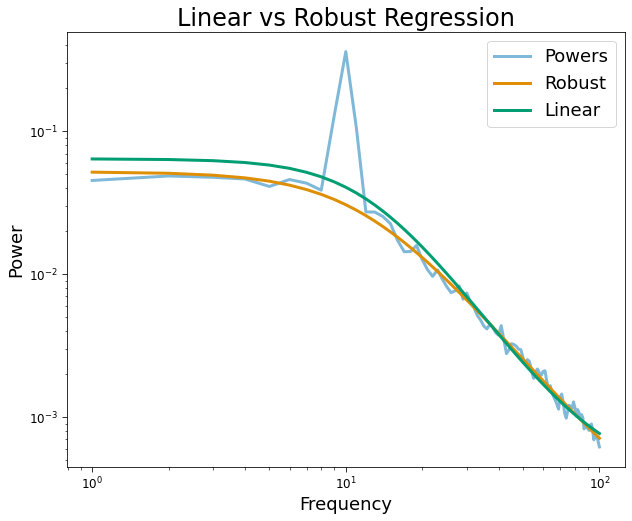

In [3]:
plt.figure(figsize=(10, 8))

plt.loglog(psd_robust.freqs, psd_robust.powers, label='Powers', alpha=.5, lw=3)
plt.loglog(psd_robust.freqs, psd_robust.powers_fit, label='Robust', lw=3)
plt.loglog(psd_linear.freqs, psd_linear.powers_fit, label='Linear', lw=3)

plt.title('Linear vs Robust Regression')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend();

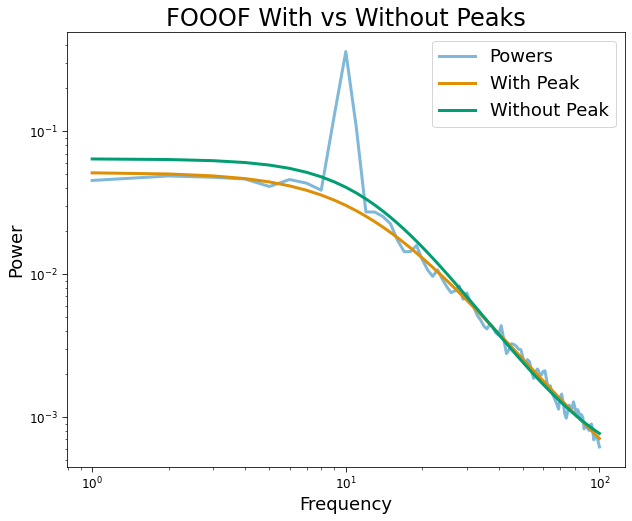

In [4]:
plt.figure(figsize=(10, 8))

plt.loglog(psd.freqs, psd.powers,
           label='Powers', alpha=.5, lw=3)
plt.loglog(psd.freqs, psd.powers_fit,
           label='With Peak', lw=3)
plt.loglog(psd.freqs, psd_nopeak.powers_fit,
           label='Without Peak', lw=3)

plt.title('FOOOF With vs Without Peaks')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend();

## Finite

Finite bias may be account for using autoregressive power spectral density instead of non-parametric estimates, such as Welch's method. Accounting for finite bias allows the use of short time windows to explore the time or task-dependent nature of timescales.

In [5]:
# Settings
n_seconds = 2
fs = 1000
freq = 10
tau = convert_knee(freq)
ar_order = 2

# Simulate
np.random.seed(0)
sig = sim_ou(n_seconds, fs, tau)

# Compute spectra
psd_ar = PSD()
psd_ar.compute_spectrum(sig, fs, ar_order=ar_order)

psd_welch = PSD()
psd_welch.compute_spectrum(sig, fs)

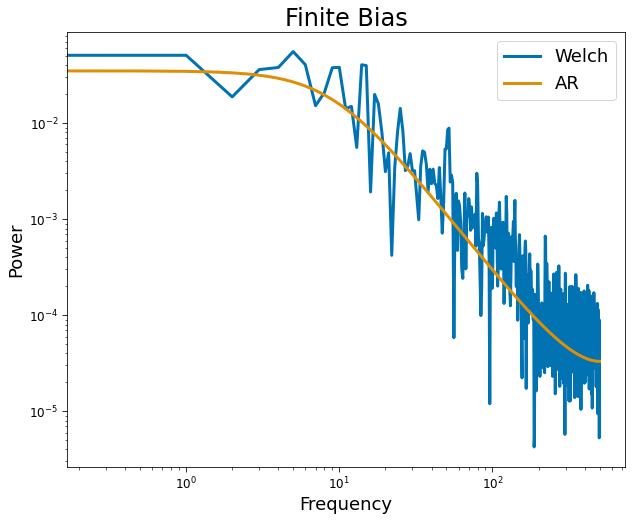

In [6]:
plt.figure(figsize=(10, 8))

plt.loglog(psd_welch.freqs, psd_welch.powers,
           label='Welch', lw=3)
plt.loglog(psd_ar.freqs, psd_ar.powers,
           label='AR', lw=3)

plt.title('Finite Bias')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend();

## Oscillations + Finite

Autoregressive PSD estimates preserve oscillatory structure by increasing the order of the model.

In [7]:
# Settings
n_seconds = 1
fs = 1000
freq = 10
tau = convert_knee(freq)
ar_order = 50

# Simulate
np.random.seed(0)
sig = sim_ou(n_seconds, fs, tau)
sig += sim_oscillation(n_seconds, fs, freq, variance=1)

# Fit
psd_ar = PSD()
psd_ar.compute_spectrum(sig, fs, ar_order=ar_order, f_range=(1, 100), nfft=10000)
psd_ar.fit(method='cauchy')

psd_welch = PSD()
psd_welch.compute_spectrum(sig, fs, f_range=(1, 100))
psd_welch.fit(method='cauchy')

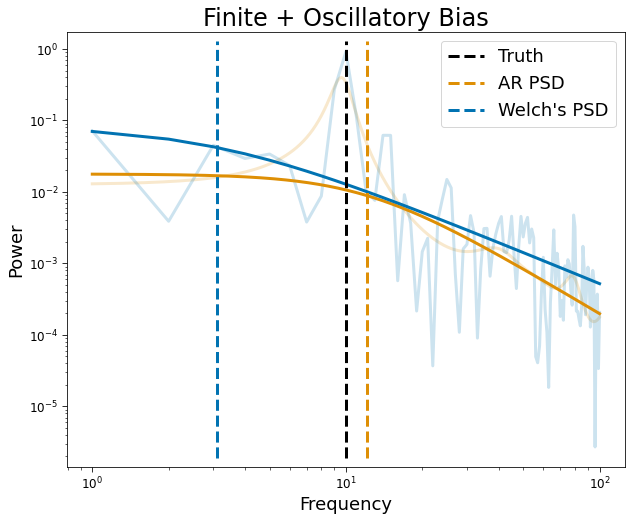

In [8]:
plt.figure(figsize=(10, 8))

plt.loglog(psd_ar.freqs, psd_ar.powers,
           lw=3, alpha=.2, color='C1')
plt.loglog(psd_welch.freqs, psd_welch.powers,
           lw=3, alpha=.2, color='C0')

           
plt.loglog(psd_ar.freqs, psd_ar.powers_fit,
           lw=3, color='C1')
plt.loglog(psd_welch.freqs, psd_welch.powers_fit,
           lw=3, color='C0')

plt.axvline(freq, .02, .98, lw=3,
            color='k', ls='--', label='Truth')
plt.axvline(psd_ar.params[1], .02, .98, lw=3,
            color='C1', ls='--', label='AR PSD')
plt.axvline(psd_welch.params[1], .02, .98, lw=3,
            color='C0', ls='--', label='Welch\'s PSD')

plt.title('Finite + Oscillatory Bias')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend();